# Peter dan Serigala: Pengenalan Pembelajaran Pengukuhan

Dalam tutorial ini, kita akan belajar bagaimana menerapkan pembelajaran pengukuhan kepada masalah mencari jalan. Situasi ini diilhamkan oleh kisah dongeng muzik [Peter dan Serigala](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) oleh komposer Rusia [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Ia adalah kisah tentang perintis muda Peter, yang dengan berani keluar dari rumahnya ke kawasan hutan untuk mengejar serigala. Kita akan melatih algoritma pembelajaran mesin yang akan membantu Peter meneroka kawasan sekitarnya dan membina peta navigasi yang optimum.

Pertama, mari kita import beberapa perpustakaan yang berguna:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Gambaran Keseluruhan Pembelajaran Pengukuhan

**Pembelajaran Pengukuhan** (RL) adalah teknik pembelajaran yang membolehkan kita mempelajari tingkah laku optimum bagi **agen** dalam suatu **persekitaran** dengan menjalankan banyak eksperimen. Agen dalam persekitaran ini seharusnya mempunyai **matlamat**, yang ditentukan oleh **fungsi ganjaran**.

## Persekitaran

Untuk memudahkan, mari kita anggap dunia Peter sebagai papan segi empat berukuran `width` x `height`. Setiap sel dalam papan ini boleh menjadi:
* **tanah**, di mana Peter dan makhluk lain boleh berjalan
* **air**, di mana jelas sekali anda tidak boleh berjalan
* **pokok** atau **rumput** - tempat di mana anda boleh berehat seketika
* **epal**, yang mewakili sesuatu yang Peter akan gembira untuk menemui bagi mengisi perutnya
* **serigala**, yang berbahaya dan harus dielakkan

Untuk bekerja dengan persekitaran ini, kita akan mendefinisikan kelas yang dipanggil `Board`. Supaya tidak terlalu memenuhi buku nota ini, semua kod untuk bekerja dengan papan telah dipindahkan ke modul `rlboard` yang berasingan, yang kini akan kita import. Anda boleh melihat dalam modul ini untuk mendapatkan lebih banyak butiran tentang dalaman pelaksanaannya.


In [2]:
from rlboard import *

Mari kita cipta papan rawak dan lihat bagaimana rupanya:


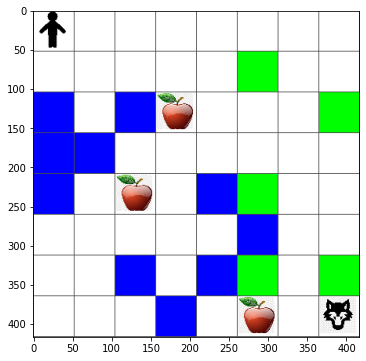

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Tindakan dan Polisi

Dalam contoh kita, matlamat Peter adalah untuk mencari epal sambil mengelakkan serigala dan halangan lain. Untuk mencapai ini, dia boleh berjalan-jalan sehingga dia menemui epal. Oleh itu, di mana-mana kedudukan, dia boleh memilih salah satu daripada tindakan berikut: atas, bawah, kiri, dan kanan. Kita akan mendefinisikan tindakan tersebut sebagai sebuah kamus, dan memetakan mereka kepada pasangan perubahan koordinat yang sepadan. Sebagai contoh, bergerak ke kanan (`R`) akan sepadan dengan pasangan `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Strategi ejen kita (Peter) ditentukan oleh apa yang dipanggil sebagai **dasar**. Mari kita pertimbangkan dasar yang paling mudah dipanggil **pergerakan rawak**.

## Pergerakan rawak

Mari kita selesaikan masalah kita terlebih dahulu dengan melaksanakan strategi pergerakan rawak.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Mari kita jalankan eksperimen jalan rawak beberapa kali dan lihat purata bilangan langkah yang diambil:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Fungsi Ganjaran

Untuk menjadikan polisi kita lebih bijak, kita perlu memahami pergerakan mana yang "lebih baik" daripada yang lain.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Bina Jadual-Q, atau array multi-dimensi. Oleh kerana papan kita mempunyai dimensi `width` x `height`, kita boleh mewakili Jadual-Q dengan array numpy dengan bentuk `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Hantarkan Jadual-Q kepada fungsi plot untuk memvisualisasikan jadual pada papan:


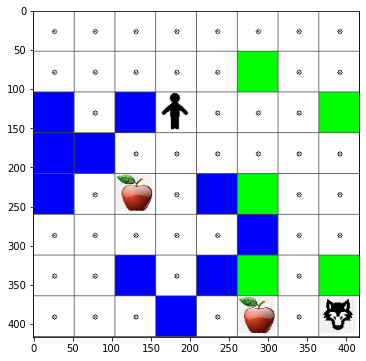

In [9]:
m.plot(Q)

## Intipati Q-Learning: Persamaan Bellman dan Algoritma Pembelajaran

Tulis pseudo-kod untuk algoritma pembelajaran kita:

* Inisialisasi Jadual Q (Q-Table) Q dengan nilai yang sama untuk semua keadaan dan tindakan
* Tetapkan kadar pembelajaran $\alpha\leftarrow 1$
* Ulang simulasi berkali-kali
   1. Mulakan di kedudukan rawak
   1. Ulang
        1. Pilih satu tindakan $a$ pada keadaan $s$
        2. Laksanakan tindakan dengan bergerak ke keadaan baru $s'$
        3. Jika kita menemui keadaan akhir permainan, atau jumlah ganjaran terlalu kecil - keluar dari simulasi  
        4. Hitung ganjaran $r$ di keadaan baru
        5. Kemas kini Fungsi Q mengikut persamaan Bellman: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Kemas kini jumlah ganjaran dan kurangkan $\alpha$.

## Eksploitasi vs. Eksplorasi

Pendekatan terbaik adalah untuk mengimbangi antara eksplorasi dan eksploitasi. Apabila kita semakin memahami persekitaran kita, kita akan lebih cenderung mengikuti laluan yang optimum, namun, memilih laluan yang belum diterokai sekali-sekala.

## Implementasi Python

Sekarang kita bersedia untuk melaksanakan algoritma pembelajaran. Sebelum itu, kita juga memerlukan beberapa fungsi yang akan menukar nombor sewenang-wenangnya dalam Jadual Q (Q-Table) kepada vektor kebarangkalian untuk tindakan yang sepadan:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Kami menambah sejumlah kecil `eps` kepada vektor asal untuk mengelakkan pembahagian dengan 0 dalam kes awal, apabila semua komponen vektor adalah sama.

Algoritma pembelajaran sebenar yang akan kita jalankan untuk 5000 eksperimen, juga dipanggil **epoch**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Selepas melaksanakan algoritma ini, Jadual-Q harus dikemas kini dengan nilai-nilai yang menentukan daya tarikan tindakan yang berbeza pada setiap langkah. Visualisasikan jadual di sini:


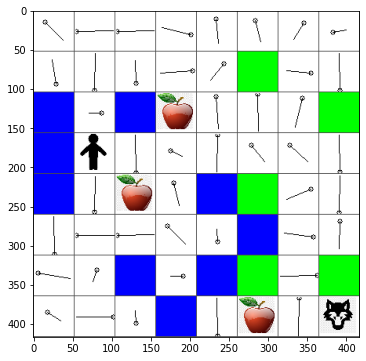

In [12]:
m.plot(Q)

## Memeriksa Polisi

Oleh kerana Q-Table menyenaraikan "daya tarikan" setiap tindakan di setiap keadaan, ia sangat mudah digunakan untuk menentukan navigasi yang efisien dalam dunia kita. Dalam kes yang paling mudah, kita hanya perlu memilih tindakan yang sepadan dengan nilai Q-Table tertinggi:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Jika anda mencuba kod di atas beberapa kali, anda mungkin perasan bahawa kadangkala ia hanya "tergantung", dan anda perlu menekan butang HENTI dalam notebook untuk menghentikannya.

> **Tugas 1:** Ubah suai fungsi `walk` untuk menghadkan panjang maksimum laluan kepada bilangan langkah tertentu (contohnya, 100), dan perhatikan kod di atas mengembalikan nilai ini dari semasa ke semasa.

> **Tugas 2:** Ubah suai fungsi `walk` supaya ia tidak kembali ke tempat yang telah dilalui sebelum ini. Ini akan menghalang `walk` daripada berulang, namun, agen masih boleh berakhir dalam keadaan "terperangkap" di lokasi yang tidak dapat dilarikan.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


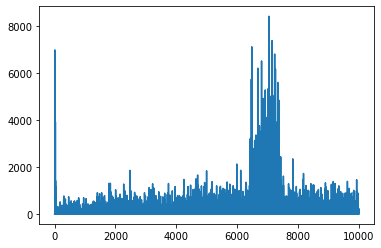

In [15]:
plt.plot(lpath)

Apa yang kita lihat di sini adalah pada mulanya purata panjang laluan meningkat. Ini mungkin disebabkan oleh fakta bahawa apabila kita tidak tahu apa-apa tentang persekitaran - kita cenderung terperangkap dalam keadaan buruk, seperti air atau serigala. Apabila kita belajar lebih banyak dan mula menggunakan pengetahuan ini, kita boleh meneroka persekitaran dengan lebih lama, tetapi kita masih belum tahu dengan baik di mana lokasi epal.

Setelah kita belajar secukupnya, menjadi lebih mudah bagi agen untuk mencapai matlamat, dan panjang laluan mula berkurang. Walau bagaimanapun, kita masih terbuka kepada penerokaan, jadi kita sering menyimpang dari laluan terbaik dan meneroka pilihan baru, menjadikan laluan lebih panjang daripada yang optimum.

Apa yang kita juga perhatikan pada graf ini adalah bahawa pada satu titik panjang laluan meningkat secara mendadak. Ini menunjukkan sifat stokastik proses tersebut, dan bahawa kita pada satu ketika boleh "merosakkan" koefisien Q-Table dengan menulis semula nilai-nilai baru. Hal ini sepatutnya diminimumkan dengan mengurangkan kadar pembelajaran (contohnya, menjelang akhir latihan kita hanya menyesuaikan nilai Q-Table dengan nilai yang kecil).

Secara keseluruhan, adalah penting untuk diingat bahawa kejayaan dan kualiti proses pembelajaran sangat bergantung pada parameter seperti kadar pembelajaran, pengurangan kadar pembelajaran, dan faktor diskaun. Parameter-parameter ini sering dipanggil **hiperparameter**, untuk membezakannya daripada **parameter** yang kita optimalkan semasa latihan (contohnya, koefisien Q-Table). Proses mencari nilai hiperparameter terbaik dipanggil **pengoptimuman hiperparameter**, dan ia layak menjadi topik yang berasingan.


## Latihan
#### Dunia Peter dan Serigala yang Lebih Realistik

Dalam situasi kita, Peter dapat bergerak hampir tanpa merasa letih atau lapar. Dalam dunia yang lebih realistik, dia perlu duduk dan berehat dari semasa ke semasa, serta makan untuk mengisi tenaga. Mari kita jadikan dunia kita lebih realistik dengan melaksanakan peraturan berikut:

1. Dengan bergerak dari satu tempat ke tempat lain, Peter kehilangan **tenaga** dan mendapat sedikit **keletihan**.
2. Peter boleh mendapatkan lebih banyak tenaga dengan memakan epal.
3. Peter boleh menghilangkan keletihan dengan berehat di bawah pokok atau di atas rumput (iaitu berjalan ke lokasi papan yang mempunyai pokok atau rumput - padang hijau).
4. Peter perlu mencari dan membunuh serigala.
5. Untuk membunuh serigala, Peter perlu mempunyai tahap tenaga dan keletihan tertentu, jika tidak dia akan kalah dalam pertempuran.

Ubah fungsi ganjaran di atas mengikut peraturan permainan, jalankan algoritma pembelajaran pengukuhan untuk mempelajari strategi terbaik bagi memenangi permainan, dan bandingkan hasil jalan rawak dengan algoritma anda dari segi jumlah permainan yang dimenangi dan kalah.


> **Note**: Anda mungkin perlu menyesuaikan hiperparameter untuk memastikan ia berfungsi, terutamanya bilangan epoch. Oleh kerana kejayaan permainan (melawan serigala) adalah peristiwa yang jarang berlaku, anda boleh menjangkakan masa latihan yang lebih lama.



---

**Penafian**:  
Dokumen ini telah diterjemahkan menggunakan perkhidmatan terjemahan AI [Co-op Translator](https://github.com/Azure/co-op-translator). Walaupun kami berusaha untuk memastikan ketepatan, sila ambil maklum bahawa terjemahan automatik mungkin mengandungi kesilapan atau ketidaktepatan. Dokumen asal dalam bahasa asalnya harus dianggap sebagai sumber yang berwibawa. Untuk maklumat yang kritikal, terjemahan manusia profesional adalah disyorkan. Kami tidak bertanggungjawab atas sebarang salah faham atau salah tafsir yang timbul daripada penggunaan terjemahan ini.
